# Results

We're going to explore the results of modifying each corpus property on each topic metric.

First, this stops the output from scrolling. Because that's annoying.

In [228]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Load some libraries...

In [1]:
% matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import *
from scipy.stats import linregress

Load the data and make some useful lists for plotting purposes...

In [361]:
four_colors = ['cornflowerblue','lightseagreen','chocolate','darkred']
corpora = ['abc_rural','abc_science','brown','wine']
topic_metrics = ['dist_uni','eff_size','exclusivity','rank1']
topic_pair_metrics = ['cos','kld','jsd']
metrics_dict = {"Distance from Uniform":"dist_uni",
                "Effective Size":"eff_size",
                "Exclusivity":"exclusivity",
                "Rank1":"rank1",
                "Cosine Distance":"cos",
                "Kullback-Leibler Divergence":"kld",
                "Jensen-Shannon Divergence":"jsd",}
metrics_dict_rev = {"dist_uni":"Distance from Uniform",
                    "eff_size":"Effective Size",
                    "exclusivity":"Exclusivity",
                    "rank1":"Rank1",
                    "cos":"Cosine Distance",
                    "kld":"Kullback-Leibler Divergence",
                    "jsd":"Jensen-Shannon Divergence"}
properties_dict = {"Number of Documents":"num_docs",
                   "Document Length":"doc_len",
                   "Stopword Presence":"sw_pres"}
properties_dict_rev = {"num_docs":"Number of Documents",
                       "doc_len":"Document Length",
                       "sw_pres":"Stopword Presence"}

# Since all the corpus properties vary so widely
# and we want to plot them on the same graph
def re_scale(items):
    oldmax = np.max(items)
    return np.array([i/oldmax for i in items])

# Load the individual dataframes
idx = 0
dfs = []
dfs_pairs = []
for i in range(len(corpora)):
    df = pd.read_csv('{}_ind_experiment_{}.csv'.format(corpora[i],idx),index_col=False)
    df_pair = pd.read_csv('{}_pair_experiment_{}.csv'.format(corpora[i],idx),index_col=False)
    df.sw_pres = df.sw_pres.round(2)
    df_pair.sw_pres = df_pair.sw_pres.round(2)
    dfs.append(df)
    dfs_pairs.append(df_pair)

Here's a look at some of the wine data...

In [4]:
dfs[3].sample(3)

,num_docs,doc_len,sw_pres,topic,top_words,dist_uni,eff_size,exclusivity,rank1
5146,369,22.0,0.3,1,style_balance_just,1052.565852,84717.738616,1.211864,9
846,123,12.0,0.6,6,just_does_depth,580.819719,4174.803340,0.276777,7
3404,246,22.0,0.6,14,nose_rough_completely,1494.700792,35326.418507,1.354042,14


And a look at the data for pairs of topics...

In [5]:
dfs_pairs[3].sample(3)

,num_docs,doc_len,sw_pres,topic_pair,cos,kld,jsd
99410,492,18.0,0.1,12_5,0.906031,0.427592,0.425052
238883,1107,22.0,0.1,10_8,0.875236,0.543104,0.536986
7275,123,8.0,0.2,5_0,0.665953,0.128656,0.131785


# Finding Correlations

Ok. Let's start. In our second round of empirical results, we saw the potential for a few relationships. Use the plot below to explore possibilities.

In [405]:
def plot_property_metric(fit,p,m,leg_loc):
    plt.close()
    for i in range(4):
        if m in topic_metrics:
            df = dfs[i]
        else:
            df = dfs_pairs[i]
        dl_s = df.doc_len.unique()
        nd_s = df.num_docs.unique()
        if p == 'num_docs':
            x = re_scale(df[(df.sw_pres==0.0)&(df.doc_len==dl_s[8])].num_docs)
            y = re_scale(df[(df.sw_pres==0.0)&(df.doc_len==dl_s[8])][m])
        elif p == "doc_len":
            x = re_scale(df[(df.sw_pres==0.0)&(df.num_docs==nd_s[8])].doc_len)
            y = re_scale(df[(df.sw_pres==0.0)&(df.num_docs==nd_s[8])][m])
        else:
            x = re_scale(df[(df.num_docs==nd_s[8])&(df.doc_len==dl_s[8])].sw_pres)
            y = re_scale(df[(df.num_docs==nd_s[8])&(df.doc_len==dl_s[8])][m])
        r = None
        if fit=='lin':
            a,b = np.polyfit(x,y,1)
            r = linregress(x,y).rvalue
            y2 = a*x+b
        elif fit=='log':
            a,b = np.polyfit(np.log(x),y,1)
            y2 = a*np.log(x)+b
        elif fit=='exp':
            a,b = np.polyfit(np.exp(x),y,1)
            y2 = a*np.exp(x)+b
        plt.scatter(x,y,s=100,alpha=0.4,marker='o',color=four_colors[i],label=None)
        if r == None:
            plt.plot(x,y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{}".format(corpora[i]))
        else:
            plt.plot(x,y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{} r={:0.2f}".format(corpora[i],r))
    plt.legend(loc=leg_loc)
    plt.xlabel("{}".format(properties_dict_rev[p]))
    plt.ylabel("{} (scaled)".format(metrics_dict_rev[m]))
    plt.title("{} and {}".format(properties_dict_rev[p],metrics_dict_rev[m]))
    plt.show()

interact(plot_property_metric,p=properties_dict,m=metrics_dict,fit=['log','exp','lin'],leg_loc=range(11))

A Jupyter Widget

<function __main__.plot_property_metric>

In [406]:
plt.savefig("figures/doc_len_dist_uni_fitted")

# Explore A Relationship

Use the plot below to further explore a relationship. In particular, explore the how the parameters of the relationship change when you modify one of the fixed background properties from before.

In [390]:
def plot_property_metric_ex(fit="log",p="num_docs",m="eff_size",explore="doc_len",leg_loc=1):
    global all_r_s,prop,met,exp
    exp = explore
    prop = p
    met = m
    plt.close()
    all_r_s = []
    for i in range(4):
        if m in topic_metrics:
            df = dfs[i]
        else:
            df = dfs_pairs[i]
        dl_s = df.doc_len.unique()
        nd_s = df.num_docs.unique()
        sw_s = df.sw_pres.unique()
        x_s = []
        y_s = []
        a_s = []
        b_s = []
        r_s = []
        if p == 'num_docs':
            if explore=='doc_len':
                bigX = dl_s
                for d in dl_s:
                    x = re_scale(df[(df.sw_pres==0.0)&(df.doc_len==d)].num_docs)
                    y = re_scale(df[(df.sw_pres==0.0)&(df.doc_len==d)][m])
                    x_s.append(x)
                    y_s.append(y)
            else:
                bigX = sw_s
                for s in sw_s:
                    x = re_scale(df[(df.sw_pres==s)&(df.doc_len==dl_s[8])].num_docs)
                    y = re_scale(df[(df.sw_pres==s)&(df.doc_len==dl_s[8])][m])
                    x_s.append(x)
                    y_s.append(y)
        elif p == "doc_len":
            if explore=='num_docs':
                bigX = nd_s
                for n in nd_s:
                    x = re_scale(df[(df.sw_pres==0.0)&(df.num_docs==n)].doc_len)
                    y = re_scale(df[(df.sw_pres==0.0)&(df.num_docs==n)][m])
                    x_s.append(x)
                    y_s.append(y)
            else:
                bigX = sw_s
                for s in sw_s:
                    x = re_scale(df[(df.sw_pres==s)&(df.doc_len==dl_s[8])].num_docs)
                    y = re_scale(df[(df.sw_pres==s)&(df.doc_len==dl_s[8])][m])
                    x_s.append(x)
                    y_s.append(y)
        else:
            if explore=='doc_len':
                bigX = dl_s
                for d in dl_s:
                    x = re_scale(df[(df.num_docs==nd_s[8])&(df.doc_len==d)].sw_pres)
                    y = re_scale(df[(df.num_docs==nd_s[8])&(df.doc_len==d)][m])
                    x_s.append(x)
                    y_s.append(y)
            else:
                bigX = sw_s
                for n in nd_s:
                    x = re_scale(df[(df.num_docs==n)&(df.doc_len==dl_s[8])].sw_pres)
                    y = re_scale(df[(df.num_docs==n)&(df.doc_len==dl_s[8])][m])
                    x_s.append(x)
                    y_s.append(y)
        if fit=='lin':
            for j in range(len(x_s)):
                a,b = np.polyfit(x_s[j],y_s[j],1)
                r = linregress(x_s[j],y_s[j]).rvalue
                a_s.append(a)
                b_s.append(b)
                r_s.append(r)
        elif fit=='log':
            for j in range(len(x_s)):
                a,b = np.polyfit(np.log(x_s[j]),y_s[j],1)
                a_s.append(a)
                b_s.append(b)
        elif fit=='exp':
            for j in range(len(x_s)):
                a,b = np.polyfit(np.exp(x_s[j]),y_s[j],1)
                a_s.append(a)
                b_s.append(b)
        all_r_s.append(r_s)
        plt.plot(re_scale(bigX),a_s,ms=10,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
        plt.plot(re_scale(bigX),b_s,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
    plt.legend(loc=leg_loc)
    plt.xlabel("{}".format(properties_dict_rev[explore]))
    plt.ylabel("{} (scaled)".format(metrics_dict_rev[m]))
    plt.title("{} and {}".format(properties_dict_rev[p],metrics_dict_rev[m]))
    plt.show()

interact(plot_property_metric_ex,p=properties_dict,m=metrics_dict,explore=properties_dict,fit=['log','exp','lin'],leg_loc=range(11))

A Jupyter Widget

<function __main__.plot_property_metric_ex>

In [400]:
plt.savefig("figures/dl_dist_uni_sw")

## Linear Best-Fit

If you were exploring a linear relationship, you can observe the effect on R's by running this cell.

<IPython.core.display.Javascript object>


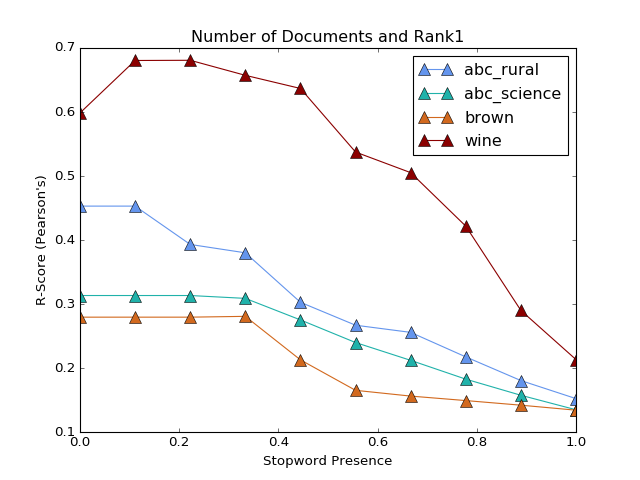

In [392]:
plt.close()
plt.title("{} and {}".format(properties_dict_rev[prop],metrics_dict_rev[met]))
plt.xlabel("{}".format(properties_dict_rev[exp]))
plt.ylabel("R-Score (Pearson's)")
for i in range(len(all_r_s)):
    r = all_r_s[i]
    x = re_scale(range(len(r)))
    plt.plot(x,r,ms=10,marker='^',label="{}".format(corpora[i]),color=four_colors[i])
plt.legend()
plt.show()

In [385]:
plt.savefig("figures/num_doc_exclusivity_doc_len_r")

## Distance from Uniform Distribution

As the number of documents increases, we observe an increase in topic distance from the uniform distribution. This increase is minor for the majority of topics but quite severe for those weaker topics that contain mostly corpus stopwords. Increasing the document length only adds to the effect, pushing topics farther from the uniform distribution. Increasing the stopword presence slightly increases variance of the scores for most topics but most severely impacts the weaker topics. At 90% stopword presence, the weakest topic is clearly distinguishable from the remainder of topics regardless of the number of documents in the corpus or their length.

<IPython.core.display.Javascript object>


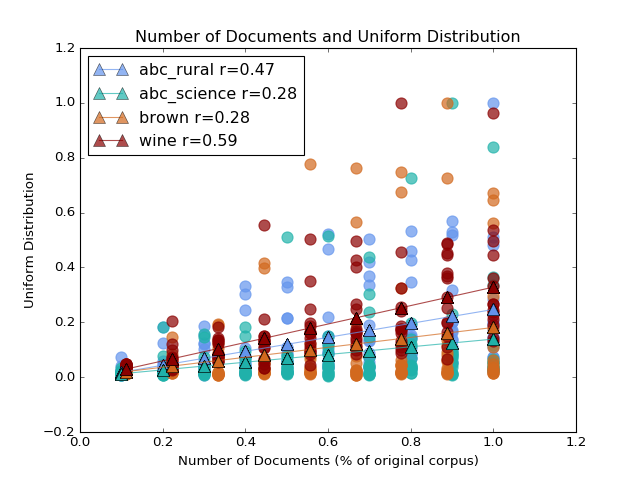

In [238]:
plt.close()
for i in range(4):
    dl_s = sorted(dfs[i].doc_len.unique())
    x = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[8])].num_docs)
    y = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[8])].dist_uni)
    a,b = np.polyfit(x,y,1)
    r = linregress(x,y).rvalue
    y2 = a*x+b
    plt.scatter(re_scale(x),y,s=100,alpha=0.7,marker='o',color=four_colors[i],label=None)
    plt.plot(re_scale(x),y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{} r={:0.2f}".format(corpora[i],r))
plt.legend(loc="upper left")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Uniform Distribution")
plt.title("Number of Documents and Uniform Distribution")
plt.show()

### Changing Document Length

This has no significant affect on the relationship except to reduce the strength of the relationship.

<IPython.core.display.Javascript object>


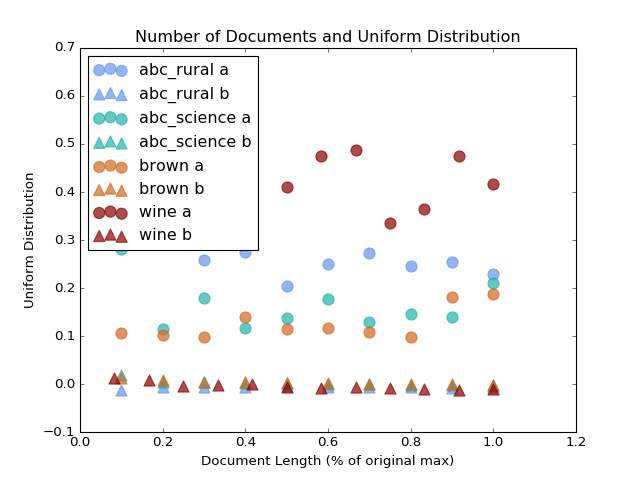

In [274]:
plt.close()
all_r_s = []
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    dl_s = sorted(dfs[i].doc_len.unique())
    for d in dl_s:
        x = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==d)].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==d)].dist_uni)
        a,b = np.polyfit(x,y,1)
        a_s.append(a)
        b_s.append(b)
        r_s.append(linregress(x,y).rvalue)
    all_r_s.append(r_s)
    plt.scatter(re_scale(dl_s),a_s,s=100,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
    plt.scatter(re_scale(dl_s),b_s,s=100,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="upper left")
plt.xlabel("Document Length (% of original max)")
plt.ylabel("Uniform Distribution")
plt.title("Number of Documents and Uniform Distribution")
plt.show()

<IPython.core.display.Javascript object>


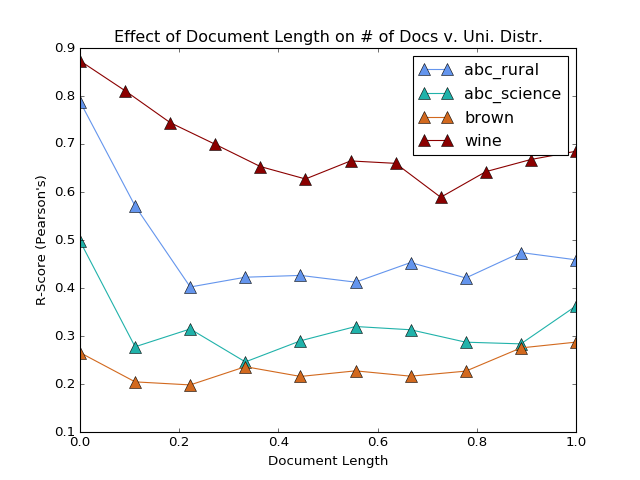

In [257]:
plt.close()
plt.title("Effect of Document Length on # of Docs v. Uni. Distr.")
plt.xlabel("Document Length")
plt.ylabel("R-Score (Pearson's)")
for i in range(len(all_r_s)):
    r = all_r_s[i]
    x = re_scale(range(len(r)))
    plt.plot(x,r,ms=10,marker='^',label="{}".format(corpora[i]),color=four_colors[i])
plt.legend()
plt.show()

In [258]:
plt.savefig("figures/doc_len_infl_num_doc_uni_distr")

### Changing Stopword Presence

Same. Only effect on increasing presence is to decrease strength of relationship.

<IPython.core.display.Javascript object>


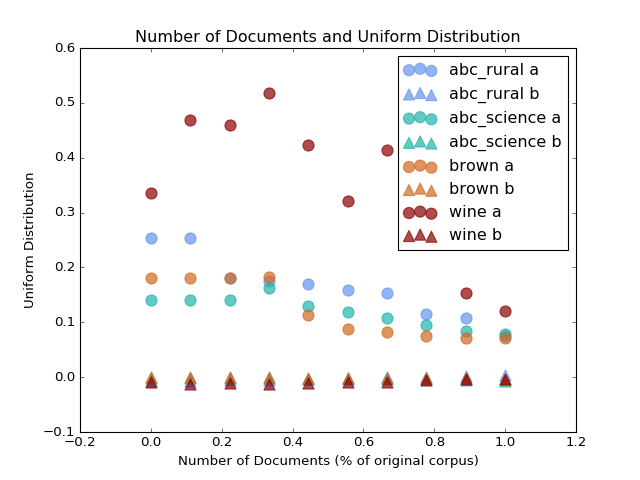

In [275]:
plt.close()
all_r_s = []
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    sw_s = [i/10 for i in range(10)]
    dl_s = sorted(dfs[i].doc_len.unique())
    for s in sw_s:
        x = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].dist_uni)
        a,b = np.polyfit(x,y,1)
        a_s.append(a)
        b_s.append(b)
        r_s.append(linregress(x,y).rvalue)
    all_r_s.append(r_s)
    plt.scatter(re_scale(sw_s),a_s,s=100,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
    plt.scatter(re_scale(sw_s),b_s,s=100,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="upper right")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Uniform Distribution")
plt.title("Number of Documents and Uniform Distribution")
plt.show()

<IPython.core.display.Javascript object>


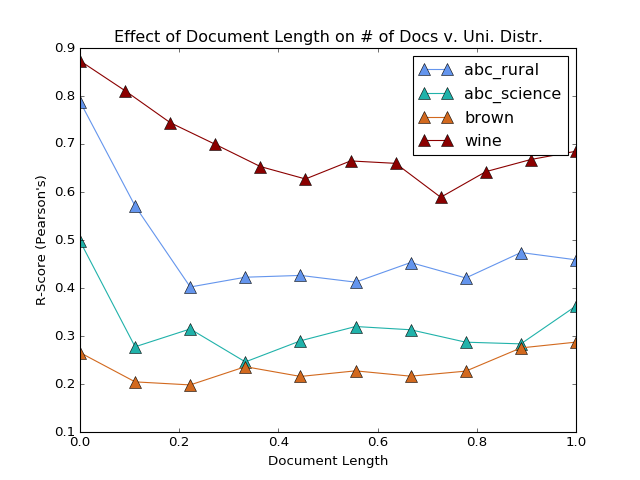

In [270]:
plt.close()
plt.title("Effect of Document Length on # of Docs v. Uni. Distr.")
plt.xlabel("Document Length")
plt.ylabel("R-Score (Pearson's)")
for i in range(len(all_r_s)):
    r = all_r_s[i]
    x = re_scale(range(len(r)))
    plt.plot(x,r,ms=10,marker='^',label="{}".format(corpora[i]),color=four_colors[i])
plt.legend()
plt.show()

## Effective Size

There is a logarithmic relationship of the form y=a*log(x)+b between the number of documents and the effective size of topics where log(x) is the natural log (base e) of x. As document length increases, the parameters for the best-fit log curve also increase. As stopword presence increases,

<IPython.core.display.Javascript object>


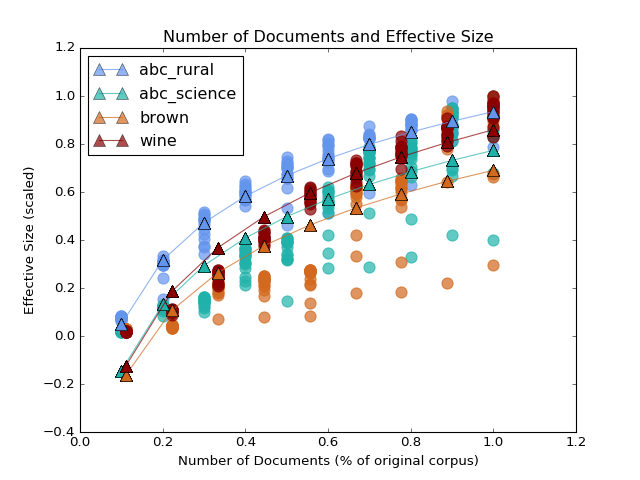

In [282]:
plt.close()
for i in range(4):
    dl_s = sorted(dfs[i].doc_len.unique())
    x = re_scale(dfs[i][(dfs[i].sw_pres==0.3)&(dfs[i].doc_len==dl_s[4])].num_docs)
    y = re_scale(dfs[i][(dfs[i].sw_pres==0.3)&(dfs[i].doc_len==dl_s[4])].eff_size)
    a,b = np.polyfit(np.log(x),y,1)
    y2 = a*np.log(x)+b
    plt.scatter(x,y,s=100,alpha=0.7,marker='o',color=four_colors[i],label=None)
    plt.plot(x,y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{}".format(corpora[i]))
plt.legend(loc="upper left")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Effective Size (scaled)")
plt.title("Number of Documents and Effective Size")
plt.show()

### Changing Document Length

Negatively affects the strength of the correlation.

<IPython.core.display.Javascript object>


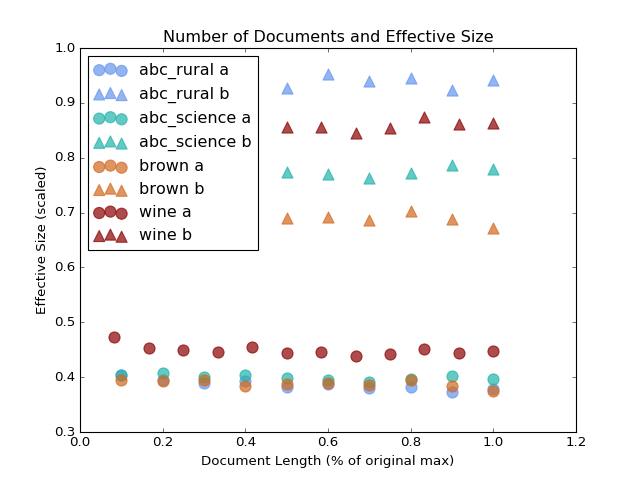

In [297]:
plt.close()
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    dl_s = sorted(dfs[i].doc_len.unique())
    for d in dl_s:
        x = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==d)].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==d)].eff_size)
        a,b = np.polyfit(np.log(x),y,1)
        a_s.append(a)
        b_s.append(b)
    plt.scatter(re_scale(dl_s),a_s,s=100,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
    plt.scatter(re_scale(dl_s),b_s,s=100,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="upper left")
plt.xlabel("Document Length (% of original max)")
plt.ylabel("Effective Size (scaled)")
plt.title("Number of Documents and Effective Size")
plt.show()

### Changing Stopword Presence

Negatively affects the strength of the relationship.

<IPython.core.display.Javascript object>


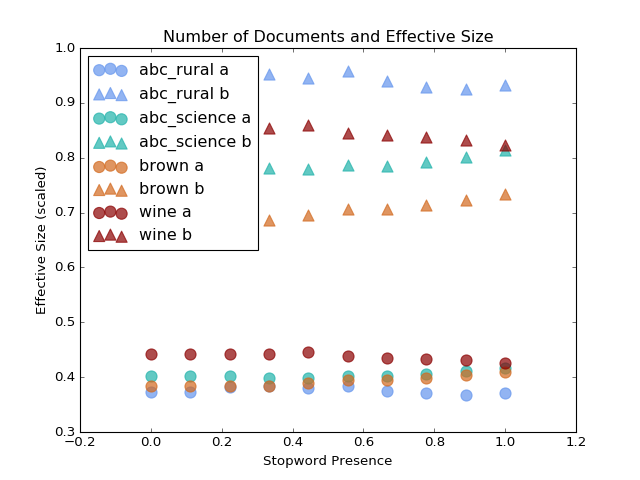

In [300]:
plt.close()
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    dl_s = sorted(dfs[i].doc_len.unique())
    sw_s = sorted(dfs[i].sw_pres.unique())
    for s in sw_s:
        x = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].eff_size)
        a,b = np.polyfit(np.log(x),y,1)
        a_s.append(a)
        b_s.append(b)
    plt.scatter(re_scale(sw_s),a_s,s=100,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
    plt.scatter(re_scale(sw_s),b_s,s=100,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="upper left")
plt.xlabel("Stopword Presence")
plt.ylabel("Effective Size (scaled)")
plt.title("Number of Documents and Effective Size")
plt.show()

## Exclusivity

<IPython.core.display.Javascript object>


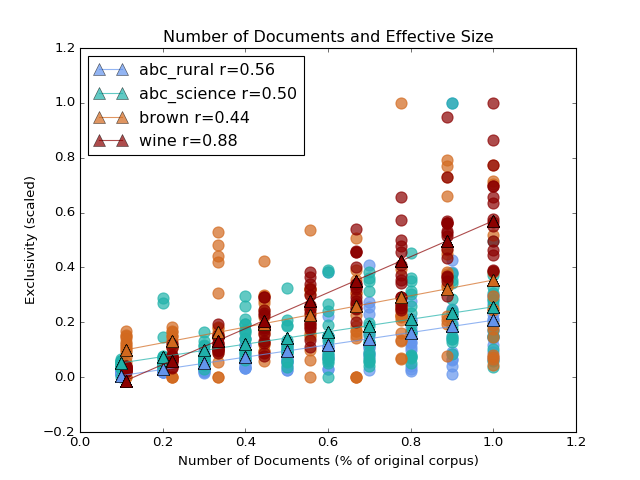

In [307]:
plt.close()
for i in range(4):
    dl_s = sorted(dfs[i].doc_len.unique())
    x = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[8])].num_docs)
    y = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[8])].exclusivity)
    a,b = np.polyfit(x,y,1)
    r = linregress(x,y).rvalue
    y2 = a*x+b
    plt.scatter(x,y,s=100,alpha=0.7,marker='o',color=four_colors[i],label=None)
    plt.plot(x,y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{} r={:0.2f}".format(corpora[i],r))
plt.legend(loc="upper left")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Exclusivity (scaled)")
plt.title("Number of Documents and Effective Size")
plt.show()

### Changing Document Length

In [ ]:
plt.close()
all_r_s = []
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    sw_s = [i/10 for i in range(10)]
    dl_s = sorted(dfs[i].doc_len.unique())
    for s in sw_s:
        x = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].dist_uni)
        a,b = np.polyfit(x,y,1)
        a_s.append(a)
        b_s.append(b)
        r_s.append(linregress(x,y).rvalue)
    all_r_s.append(r_s)
    plt.scatter(re_scale(sw_s),a_s,s=100,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
    plt.scatter(re_scale(sw_s),b_s,s=100,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="upper right")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Uniform Distribution")
plt.title("Number of Documents and Uniform Distribution")
plt.show()

### Changing Stopword Presence

In [ ]:
plt.close()
all_r_s = []
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    dl_s = sorted(dfs[i].doc_len.unique())
    sw_s = sorted(dfs[i].sw_pres.unique())
    for s in sw_s:
        x = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].eff_size)
        a,b = np.polyfit(x,y,1)
        r = linregress(x,y).rvalue
        a_s.append(a)
        b_s.append(b)
        r_s.append(r)
    all_r_s.append(r_s)
    plt.scatter(re_scale(sw_s),a_s,s=100,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
    plt.scatter(re_scale(sw_s),b_s,s=100,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="upper left")
plt.xlabel("Stopword Presence")
plt.ylabel("Effective Size (scaled)")
plt.title("Number of Documents and Effective Size")
plt.show()

## Rank1

<IPython.core.display.Javascript object>


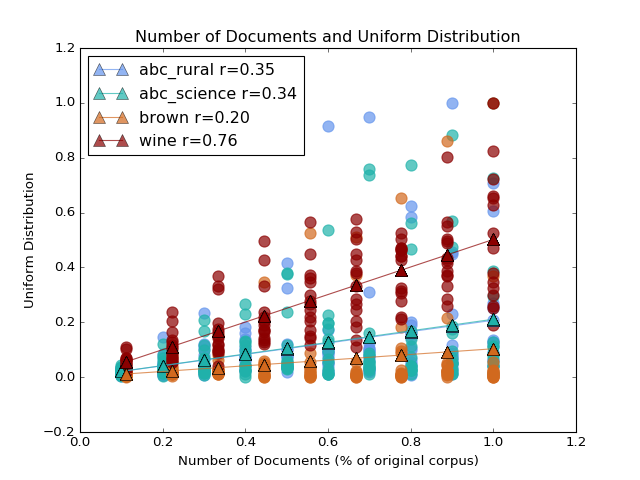

In [316]:
plt.close()
for i in range(4):
    dl_s = sorted(dfs[i].doc_len.unique())
    x = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[2])].num_docs)
    y = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[2])].rank1)
    a,b = np.polyfit(x,y,1)
    r = linregress(x,y).rvalue
    y2 = a*x+b
    plt.scatter(re_scale(x),y,s=100,alpha=0.7,marker='o',color=four_colors[i],label=None)
    plt.plot(re_scale(x),y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{} r={:0.2f}".format(corpora[i],r))
plt.legend(loc="upper left")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Uniform Distribution")
plt.title("Number of Documents and Uniform Distribution")
plt.show()

### Changing Document Length

<IPython.core.display.Javascript object>


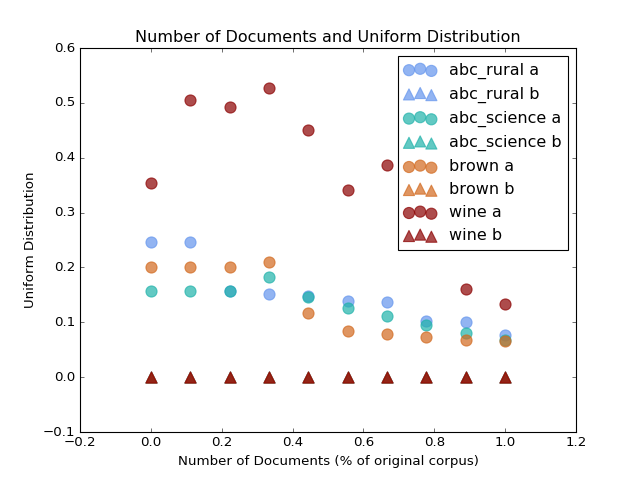

In [322]:
plt.close()
all_r_s = []
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    sw_s = [i/10 for i in range(10)]
    dl_s = sorted(dfs[i].doc_len.unique())
    for s in sw_s:
        x = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==s)&(dfs[i].doc_len==dl_s[8])].rank1)
        a,b = np.polyfit(x,y,1)
        a_s.append(a)
        b_s.append(b)
        r_s.append(linregress(x,y).rvalue)
    all_r_s.append(r_s)
    plt.scatter(re_scale(sw_s),a_s,s=100,alpha=0.7,marker='o',color=four_colors[i],label="{} a".format(corpora[i]))
    plt.scatter(re_scale(sw_s),b_s,s=100,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="upper right")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Uniform Distribution")
plt.title("Number of Documents and Uniform Distribution")
plt.show()

## Document Length

Exclusivity looked like a small linear increase.

In [ ]:
def plot_metric(fit,p,m):
    plt.close()
    for i in range(4):
        dl_s = sorted(dfs[i].doc_len.unique())
        x = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[8])].num_docs)
        y = re_scale(dfs[i][(dfs[i].sw_pres==0.0)&(dfs[i].doc_len==dl_s[8])][m])
        if fit=='lin':
            a,b = np.polyfit(x,y,1)
            r = linregress(x,y).rvalue
            y2 = a*x+b
        elif fit=='log':
            a,b = np.polyfit(np.log(x),y,1)
            y2 = a*np.log(x)+b
        elif fit=='exp':
            a,b = np.polyfit(np.exp(x),y,1)
            y2 = a*np.exp(x)+b
        plt.scatter(x,y,s=100,alpha=0.7,marker='o',color=four_colors[i],label=None)
        plt.plot(x,y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{} r={:0.2f}".format(corpora[i],r))
    plt.legend(loc="upper left")
    plt.xlabel("{}".format(p))
    plt.ylabel("{} (scaled)".format(metrics_dict_rev[m]))
    plt.title("{} and {}".format(p,metrics_dict_rev[m]))
    plt.show()

interact(plot_metric,p=properties_dict,m=metrics_dict)

### Changing Number of Documents

### Changing Stopword Presence

<IPython.core.display.Javascript object>


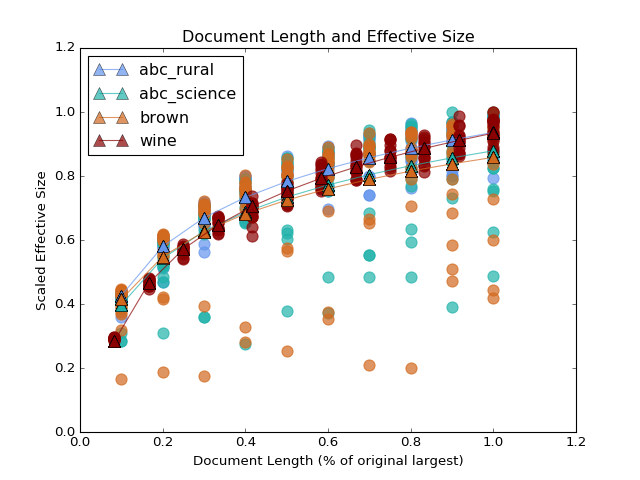

In [226]:
four_colors = ['cornflowerblue','lightseagreen','chocolate','darkred']

plt.close()
for i in range(4):
    r_s = []
    nd = sorted(dfs[i].num_docs.unique())[8]
    x = dfs[i][(dfs[i].sw_pres==0.3)&(dfs[i].num_docs==nd)].doc_len
    y = re_scale(dfs[i][(dfs[i].sw_pres==0.3)&(dfs[i].num_docs==nd)].eff_size)
    a,b = np.polyfit(np.log(x),y,1)
    y2 = a*np.log(x)+b
#     r = linregress(x,y).rvalue
    plt.scatter(re_scale(x),y,s=100,alpha=0.7,marker='o',color=four_colors[i],label=None)
    plt.plot(re_scale(x),y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{}".format(corpora[i]))
plt.legend(loc="upper left")
plt.xlabel("Document Length (% of original largest)")
plt.ylabel("Scaled Effective Size")
plt.title("Document Length and Effective Size")
plt.show()

In [227]:
plt.savefig("figures/doc_len_eff_size_log_plot_sw3_nd8")

<IPython.core.display.Javascript object>


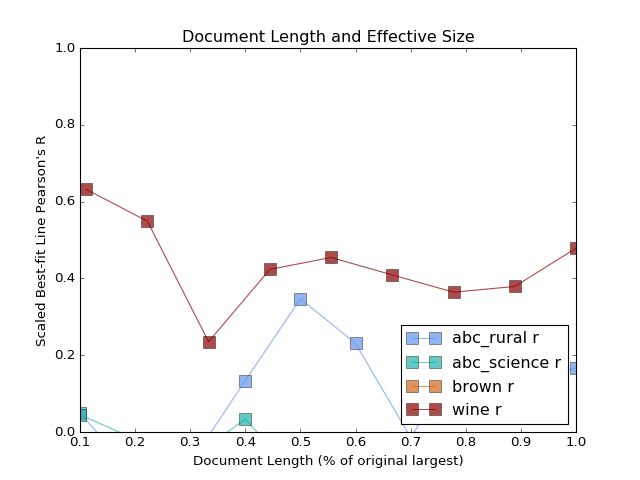

In [154]:
four_colors = ['cornflowerblue','lightseagreen','chocolate','darkred']

plt.close()
for i in range(4):
    a_s = []
    b_s = []
    r_s = []
    nd_s = sorted(dfs[i].num_docs.unique())
    for nd in nd_s:
        x = dfs[i][(dfs[i].sw_pres==0.5)&(dfs[i].num_docs==nd)].doc_len
        y = dfs[i][(dfs[i].sw_pres==0.5)&(dfs[i].num_docs==nd)].exclusivity
        a,b = np.polyfit(x,y,1)
        r_s.append(linregress(x,y).rvalue)
        a_s.append(a)
        b_s.append(b)
    plt.plot(re_scale(nd_s),r_s,ms=10,alpha=0.7,marker='s',color=four_colors[i],label="{} r".format(corpora[i]))
#     plt.plot(re_scale(nd_s),re_scale(a_s),ms=10,alpha=0.7,marker='o',color=four_colors[i],label="{} m".format(corpora[i]))
#     plt.plot(re_scale(nd_s),re_scale(b_s),ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{} b".format(corpora[i]))
plt.legend(loc="lower right")
plt.xlabel("Document Length (% of original largest)")
plt.ylabel("Scaled Best-fit Line Pearson's R")
plt.ylim(0,1)
plt.title("Document Length and Effective Size")
plt.show()

In [ ]:
four_colors = ['cornflowerblue','lightseagreen','chocolate','darkred']

plt.close()
for i in range(4):
    dl_s = sorted(dfs[i].doc_len.unique())
    x = dfs[i][(dfs[i].sw_pres==0.3)&(dfs[i].doc_len==dl_s[8])].num_docs
    y = dfs[i][(dfs[i].sw_pres==0.3)&(dfs[i].doc_len==dl_s[8])].rank1
    a,b = np.polyfit(x,y,1)
    print(a,b)
    y2 = a*x+b

    plt.scatter(re_scale(x),y,s=100,alpha=0.7,marker='o',color=four_colors[i],label=None)
    plt.plot(re_scale(x),y2,ms=10,alpha=0.7,marker='^',color=four_colors[i],label="{}".format(corpora[i]))
plt.legend(loc="upper left")
plt.xlabel("Number of Documents (% of original corpus)")
plt.ylabel("Exclusivity")
plt.title("Number of Documents and Exclusivity")
plt.show()